# Dog Breed Classification using ResNet50

**Description**: This notebook includes using AWS to finetune ResNet50 model in order to classify dog breeds. Some AWS tools like SageMaker Debugger, profiler, and hyperparameter tuning are used. Finally, the model is deployed as an endpoint and used for inference 


In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 41.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.19
    Uninstalling botocore-1.24.19:
      Successfully uninstalled botocore-1.24.19
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.27.35 requires botocore==1.29.35, but you have botocore 1.29.44 which is incompatible.
aiobotocore 2.0.1 requires botocore<1.22.9,>=1.22.8, but you have botocore 1.29.44 which is incompatible.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.


In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import os
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Dataset
The dataset contains 133 different dog breeds. The dataset is splitted into training, validation, and testing set each in a separate directory.

In [ ]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-01-03 17:27:43--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.56
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  47.9MB/s    in 23s     

2023-01-03 17:28:17 (47.4 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Af

In [6]:
# upload the datset to S3 bucket

s3_path = sagemaker.Session().upload_data(bucket='sagemaker-us-east-1-066783629629', 
                                                  path='./dogImages', 
                                                  key_prefix='dog-breed-project')

## Dataset EDA

In [9]:
dataset_local_path = './dogImages'
train_dir = os.path.join(dataset_local_path, 'train')
val_dir = os.path.join(dataset_local_path, 'valid')
test_dir = os.path.join(dataset_local_path, 'test')

# get breed class names from dirs
breed_classes_dirs = os.listdir(train_dir)
breed_classes = [breed_class.split('.')[1] for breed_class in breed_classes_dirs]

In [13]:
# calculate number of each class for our train, val, test split
train_imgs_num = []
val_imgs_num=[]
test_imgs_num=[]
for class_dir in breed_classes_dirs:
    train_imgs_num.append(len(os.listdir(os.path.join(train_dir, class_dir))))
    val_imgs_num.append(len(os.listdir(os.path.join(val_dir, class_dir))))
    test_imgs_num.append(len(os.listdir(os.path.join(test_dir, class_dir))))

In [17]:
# put the results into a df
df=pd.DataFrame({
    "Dog Breed Classes": breed_classes,
    "num in train":train_imgs_num, 
    "num in valid":val_imgs_num,
    "num in test":test_imgs_num
})

df.head()

,Dog Breed Classes,num in train,num in valid,num in test
0,Otterhound,35,5,4
1,Norwegian_lundehund,33,4,4
2,Silky_terrier,41,5,5
3,Japanese_chin,57,7,7
4,Kuvasz,49,6,6


In [21]:
# checking data imbalance
df.describe()

,num in train,num in valid,num in test
count,133.000000,133.000000,133.000000
mean,50.225564,6.278195,6.285714
std,11.863885,1.350384,1.712571
min,26.000000,4.000000,3.000000
25%,42.000000,6.000000,5.000000
50%,50.000000,6.000000,6.000000
75%,61.000000,7.000000,8.000000
max,77.000000,9.000000,10.000000


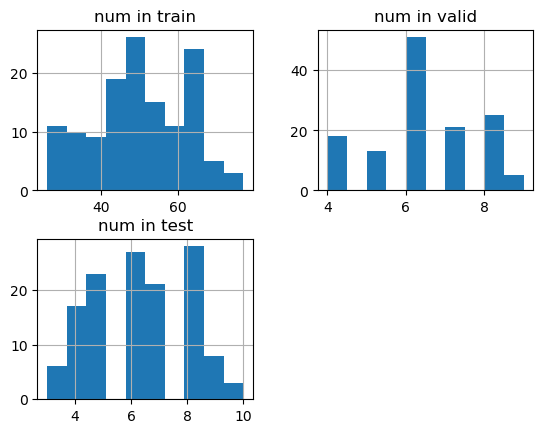

In [22]:
df.hist();

From the EDA it appears that the classes are balanced, checking the min and max values of images present in each class. the difference is not big. 

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [22]:
from sagemaker.tuner import (
    IntegerParameter, 
    ContinuousParameter, 
    CategoricalParameter, 
    HyperparameterTuner
)
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role

I chose three hyperparameters
1. number of epochs: this is an important hyperparameter to determine the length of the training and reach optimal results without overfitting.
2. learning rate: the learning rate is important to reach our minima, we need a value that is is not so large that the model oscilates and misses the minimum point nor too small that the weight updates are small
3. batch size: optimally we want to fit our whole dataset and make updates based on it, but this is computationally not possible, therefore, we need to choose a batch size big enough and compatible with our resources

In [4]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "epochs": CategoricalParameter([2, 3, 4]),
    "lr": ContinuousParameter(0.0001, 0.01),
    "batch-size": CategoricalParameter([32, 64, 128, 256])
}

In [11]:
#TODO: Create estimators for your HPs
role = get_execution_role()

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

# I will optimize on minimizing the validation loss
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]


tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [13]:
# TODO: Fit your HP Tuner
s3_path = 's3://sagemaker-us-east-1-066783629629/dog-breed-project'
tuner.fit({'data': s3_path}, wait=True) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [14]:
tuner.best_training_job()

'pytorch-training-230105-1320-002-80883a5e'

In [15]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-01-05 15:29:07 Starting - Preparing the instances for training
2023-01-05 15:29:07 Downloading - Downloading input data
2023-01-05 15:29:07 Training - Training image download completed. Training in progress.
2023-01-05 15:29:07 Uploading - Uploading generated training model
2023-01-05 15:29:07 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"256"',
 'epochs': '"4"',
 'lr': '0.005631435857646544',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-01-05-13-20-34-862"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-066783629629/pytorch-training-2023-01-05-13-20-34-862/source/sourcedir.tar.gz"'}

In [19]:
best_estimator_hyperparameters = best_estimator.hyperparameters()

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [17]:
from sagemaker.debugger import Rule, DebuggerHookConfig, rule_configs,  ProfilerRule, ProfilerConfig, FrameworkProfile

In [18]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

In [ ]:
# getting best hyperparameter  from the hyperparameter tuning step
hyperparameters = {
    "epochs": best_estimator_hyperparameters['epochs'].strip('"'),
    "lr": best_estimator_hyperparameters['lr'],
    "batch-size": best_estimator_hyperparameters['batch-size'].strip('"')
}

print(hyperparameters)

In [25]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    entry_point="train_model.py",
    base_job_name="Breed-classification",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [26]:
estimator.fit({'data': s3_path}, wait=True)

2023-01-05 16:02:00 Starting - Starting the training job...
2023-01-05 16:02:26 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2023-01-05 16:03:47 Downloading - Downloading input data......
2023-01-05 16:04:47 Training - Downloading the training image..................
2023-01-05 16:07:53 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-01-05 16:08:04,222 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-01-05 16:08:04,251 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-01-05 16:08:04,254 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-01-05 16:08:04,54

In [4]:
# TODO: Plot a debugging output.
session = boto3.session.Session()
region = session.region_name

training_job_name = "Breed-classification-2023-01-05-16-01-59-814"
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")


Training jobname: Breed-classification-2023-01-05-16-01-59-814
Region: us-east-1


In [5]:
import smdebug

In [6]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

import IPython

[2023-01-06 10:57:06.979 ip-172-16-39-66.ec2.internal:11596 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [7]:
trial = create_trial("s3://sagemaker-us-east-1-066783629629/Breed-classification-2023-01-05-16-01-59-814/debug-output/")


print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

[2023-01-06 10:57:13.906 ip-172-16-39-66.ec2.internal:11596 INFO s3_trial.py:42] Loading trial  at path s3://sagemaker-us-east-1-066783629629/Breed-classification-2023-01-05-16-01-59-814/debug-output/
[2023-01-06 10:57:14.516 ip-172-16-39-66.ec2.internal:11596 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-01-06 10:57:15.534 ip-172-16-39-66.ec2.internal:11596 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.bias', 'gradient/ResNet_fc.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.1.relu_input_2', 'layer2.2.relu_input_0', 'layer2.2.relu_input_1', 'layer2.2.relu_input_2', 'layer2.3.relu_input_0', 'laye

In [7]:
# loss plotting for debugging

from mpl_toolkits.axes_grid1 import host_subplot

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


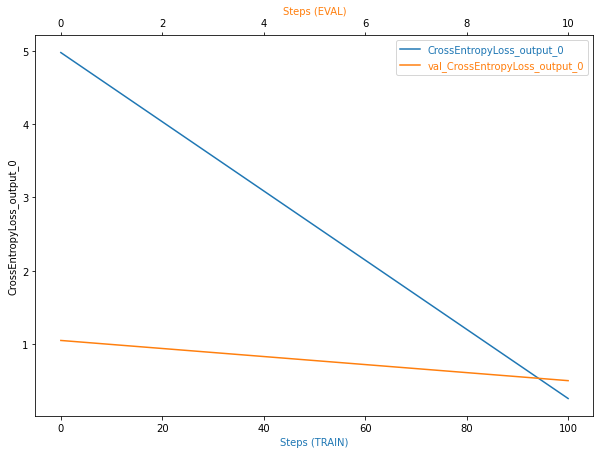

In [8]:
plot_tensor(trial, 'CrossEntropyLoss_output_0')

The plot shows that loss is decreasing which is the expected behavior. 

If there were an error, I would consider that my loss function is the correct one for my problem and debug my code for any bugs. I might also take a look at the logs in Cloudwatch to determine if the logged metrics are as expected.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [8]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-066783629629/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-066783629629/Breed-classification-2023-01-05-16-01-59-814/profiler-output


Profiler data from system is available


In [9]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

In [14]:
# TODO: Display the profiler output

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU"],
    select_events=["total"],
)

output_path = "s3://sagemaker-us-east-1-066783629629/"
rule_output_path = output_path +training_job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

select events:['total']
select dimensions:['CPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1'}


You will find the profiler report in s3://sagemaker-us-east-1-066783629629/Breed-classification-2023-01-05-16-01-59-814/rule-output


In [15]:
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

2023-01-05 17:02:07     434460 Breed-classification-2023-01-05-16-01-59-814/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-01-05 17:02:06     293330 Breed-classification-2023-01-05-16-01-59-814/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-01-05 17:02:01        547 Breed-classification-2023-01-05-16-01-59-814/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-01-05 17:02:01     273074 Breed-classification-2023-01-05-16-01-59-814/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-01-05 17:02:01       1985 Breed-classification-2023-01-05-16-01-59-814/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-01-05 17:02:01        130 Breed-classification-2023-01-05-16-01-59-814/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-01-05 17:02:01       9845 Breed-classification-2023-01-05-16-01-59-814/rule-output/ProfilerReport

In [20]:
IPython.display.HTML(filename="ProfilerReport" + "/profiler-output/profiler-report.html")

## Model Deploying

In [48]:
# TODO: Deploy your model to an endpoint
estimator_path = "s3://sagemaker-us-east-1-066783629629/Breed-classification-2023-01-05-16-01-59-814/output/model.tar.gz"
trained_model = PyTorch(
    model_data=estimator_path,
    entry_point="./infernce2.py",
    framework_version="1.8",
    py_version="py36",
    role=get_execution_role())
my_estimator = trained_model.attach(training_job_name)

predictor=my_estimator.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge")  # TODO: Add your deployment configuration like instance type and number of instances


2023-01-05 17:02:28 Starting - Preparing the instances for training
2023-01-05 17:02:28 Downloading - Downloading input data
2023-01-05 17:02:28 Training - Training image download completed. Training in progress.
2023-01-05 17:02:28 Uploading - Uploading generated training model
2023-01-05 17:02:28 Completed - Training job completed
-----!

In [49]:
import requests
request_dict={ "url": "https://sagemaker-us-east-1-066783629629.s3.amazonaws.com/dog-breed-project/test/001.Affenpinscher/Affenpinscher_00003.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

In [52]:
response = predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [58]:
import numpy as np
np.argmax(response, 1)

array([0])

In [57]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()